In [2]:
from Utils import load_results, loadBestKnown
import numpy as np

In [3]:
bk_solutions = {f"j30{i//10 + 1}_{(i%10)+1}": makespan for i, makespan in enumerate(loadBestKnown(30))}
bk_solutions = {f"j60{i//10 + 1}_{(i%10)+1}": makespan for i, makespan in enumerate(loadBestKnown(60))} | bk_solutions
bk_solutions = {f"j120{i//10 + 1}_{(i%10)+1}": makespan for i, makespan in enumerate(loadBestKnown(120))} | bk_solutions

In [4]:
def calculate_auc(values):
    """
    Calculate the Area Under the Curve (AUC) using the trapezoidal rule.
    
    Parameters:
        values (list of int or float): Sequence of performance values over time.
        
    Returns:
        float: Area under the curve.
    """
    if not values or len(values) < 2:
        return 0.0

    auc = 0.0
    for i in range(1, len(values)):
        # Trapezoid area between two points: (y1 + y2) / 2 * delta_x
        auc += (values[i-1] + values[i]) / 2  # delta_x assumed to be 1

    return auc

In [188]:
def desviations(filename: str, cycles=None):
    results = load_results(filename=filename)
    results = sorted(results, key=lambda x: x.problem_id)
    if cycles is None:
        return np.array([result.best.makespan - bk_solutions[result.problem_id] for result in results])
    return np.array([result.best_history[:cycles+1][-1] - bk_solutions[result.problem_id] for result in results])
    

def auc_data(filename: str, cycles=None):
    results = load_results(filename=filename)
    results = sorted(results, key=lambda x: x.problem_id)
    if cycles is None:
        return np.array([calculate_auc(result.best_history) for result in results])
    return np.array([calculate_auc(result.best_history[:cycles]) for result in results])

In [7]:
def print_results(filename: str):
    results = load_results(filename=filename)
    cycles = np.array([len(result.best_history) for result in results])
    print(filename.upper())
    print("---------------------------")
    print(f"Average number of cycles: {np.average(cycles)}")
    print(f"Standar desviation: {np.std(cycles)}")
    print(f"Minimum cycles: {np.min(cycles)}")
    print(f"Maximum cycles: {np.max(cycles)}")
    print("")
    data = desviations(filename=filename)
    print(f"Average number of desviation: {np.average(data)}")
    print(f"Standar desviation (of desviations): {np.std(data)}")
    print(f"Minimum desviation: {np.min(data)}")
    print(f"Maximum desviation: {np.max(data)}")
    print("---------------------------")
    print("")

In [6]:
from scipy.stats import kstest, norm, wilcoxon
import numpy as np

def isNormalDistribution(samples):
    data = np.array(samples)
    stat, p = kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"K-S Test: Statistic={stat}, p-value={p}")
    if p > 0.05:
        print("Data looks Gaussian")
    else:
        print("Data does NOT look Gaussian")


def wilcoxon_ranked_test(d1, d2):
    model1_scores = np.array(d1)
    model2_scores = np.array(d2)

    # Run Wilcoxon signed-rank test
    stat, p = wilcoxon(model1_scores, model2_scores)

    print(f"Wilcoxon Test: Statistic={stat}, p-value={p}")
    if p < 0.05:
        print("Significant difference between the two models")
    else:
        print("No significant difference between the two models")


In [ ]:
print_results(filename="Results/j30-N17-L125-P45-S15.json")

In [ ]:
proportions = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
samplings = [10, 15, 20, 25, 30, 35]

for p in proportions:
    for s in samplings:
        print_results(filename=f"Results/j120-N17-L125-P{int(p*100)}-S{s}.json")

In [243]:
dataset = "j30"
filename1 = f"Results/{dataset}-random-init-abc.json"
filename2 = f"Results/{dataset}-local-search-abc.json"
data1 = desviations(filename=filename1)
data2 = desviations(filename=filename2)
convergence1 = auc_data(filename=filename1)
convergence2 = auc_data(filename=filename2)

Results successfully loaded from Results/j30-random-init-abc.json
Results successfully loaded from Results/j30-local-search-abc.json
Results successfully loaded from Results/j30-random-init-abc.json
Results successfully loaded from Results/j30-local-search-abc.json


In [236]:
cycles = np.arange(2, 2000)
auc_evolution = []
for cycle in cycles:
    auc1 = auc_data(filename=filename1, cycles=cycle)
    auc2 = auc_data(filename=filename2, cycles=cycle)
    auc_evolution.append((auc1, auc2))

Results successfully loaded from Results/j30-random-init-abc.json
Results successfully loaded from Results/j30-local-search-abc.json
Results successfully loaded from Results/j30-random-init-abc.json
Results successfully loaded from Results/j30-local-search-abc.json
Results successfully loaded from Results/j30-random-init-abc.json
Results successfully loaded from Results/j30-local-search-abc.json
Results successfully loaded from Results/j30-random-init-abc.json
Results successfully loaded from Results/j30-local-search-abc.json
Results successfully loaded from Results/j30-random-init-abc.json
Results successfully loaded from Results/j30-local-search-abc.json
Results successfully loaded from Results/j30-random-init-abc.json
Results successfully loaded from Results/j30-local-search-abc.json
Results successfully loaded from Results/j30-random-init-abc.json
Results successfully loaded from Results/j30-local-search-abc.json
Results successfully loaded from Results/j30-random-init-abc.json
Res

In [237]:
auc_evolution = np.array(auc_evolution)
auc_evolution_avg = np.average(auc_evolution, axis=2)
print(auc_evolution_avg.shape)

(1998, 2)


In [238]:
pvalues = []
for samples in auc_evolution:
    data1 = samples[0]
    data2 = samples[1]
    pvalues.append(wilcoxon(data1, data2)[1])

In [239]:
print(auc_evolution_avg[0])
p_values = np.array(pvalues)

[74.72708333 72.046875  ]


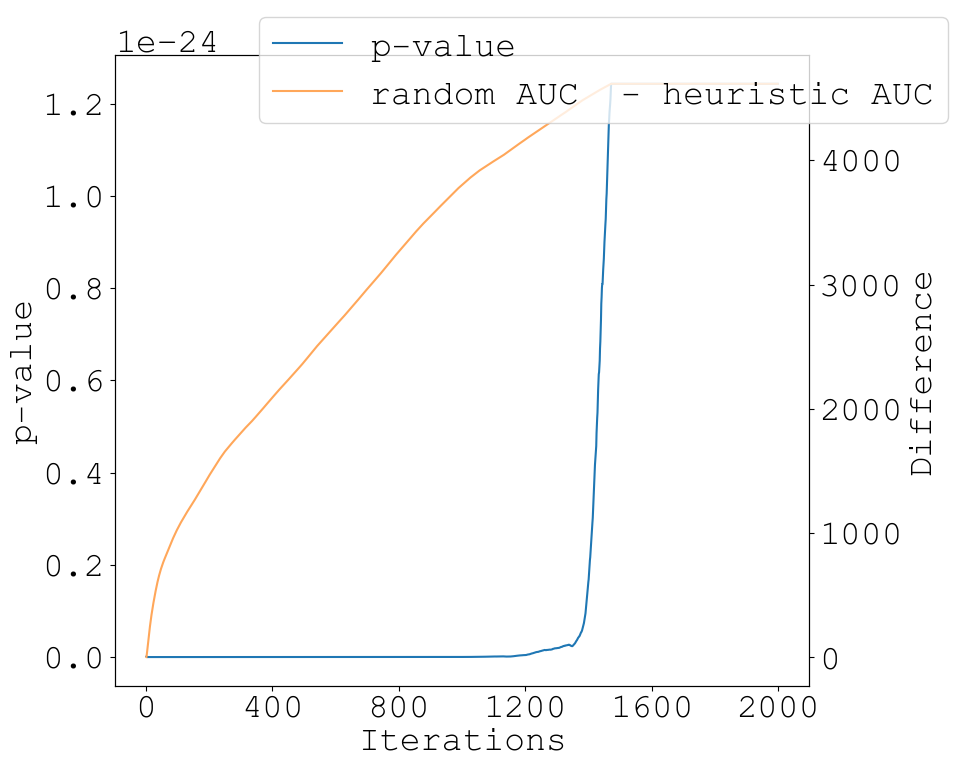

[]


In [242]:
import matplotlib.pyplot as plt
# Sample data
x = cycles
y1 = p_values      # First dataset
y2 = [d[0] - d[1] for d in auc_evolution_avg]

threshold = 0.05
diff = p_values - threshold
crossings = np.where(np.diff(np.sign(diff)))[0]

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 8))

color1 = '#1f77b4'  # blue from Tableau palette
color2 = "#ffa75a"  # orange from Tableau palette

# Plot the first dataset
ax1.plot(x, y1, label='p-value', color=color1)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('p-value')
# ax1.set_yticks(np.arange(0.0, 0.11, 0.01))
ax1.tick_params(axis='y')
ax1.set_xticks(np.arange(0, 2001, 400))

ax2 = ax1.twinx()
ax2.plot(x, y2, color=color2, label='random AUC  - heuristic AUC')
# ax2.plot(x, y3, color=color3, label='heuristic AUC')
ax2.set_ylabel('Difference')
ax2.tick_params(axis='y')

for cross in crossings[:3]:
    plt.axvline(x=cross, linestyle='--', color='gray')

fig.legend()
plt.tight_layout()
# Show the plot
# plt.title("Population diversity")
plt.savefig(f"../Assets/{dataset}-local-search-p-value.pdf")
plt.show()

print(crossings)

In [244]:
data1 = convergence1
data2 = convergence2

In [245]:
print(np.average(data1), np.std(data1))
print(np.average(data2), np.std(data2))

isNormalDistribution(data1)
isNormalDistribution(data2)

wilcoxon_ranked_test(data1, data2)

# j30: 0.5096
# j60: 0.5382
# j120: 0.1068

35573.52916666667 44500.38689596772
30958.236458333333 43219.62197302844
K-S Test: Statistic=0.2594067007202884, p-value=5.58503094266814e-29
Data does NOT look Gaussian
K-S Test: Statistic=0.3015746891103456, p-value=3.2040281404730886e-39
Data does NOT look Gaussian
Wilcoxon Test: Statistic=26569.0, p-value=1.2429616716076652e-24
Significant difference between the two models


Number of zero differences: 1 out of 480


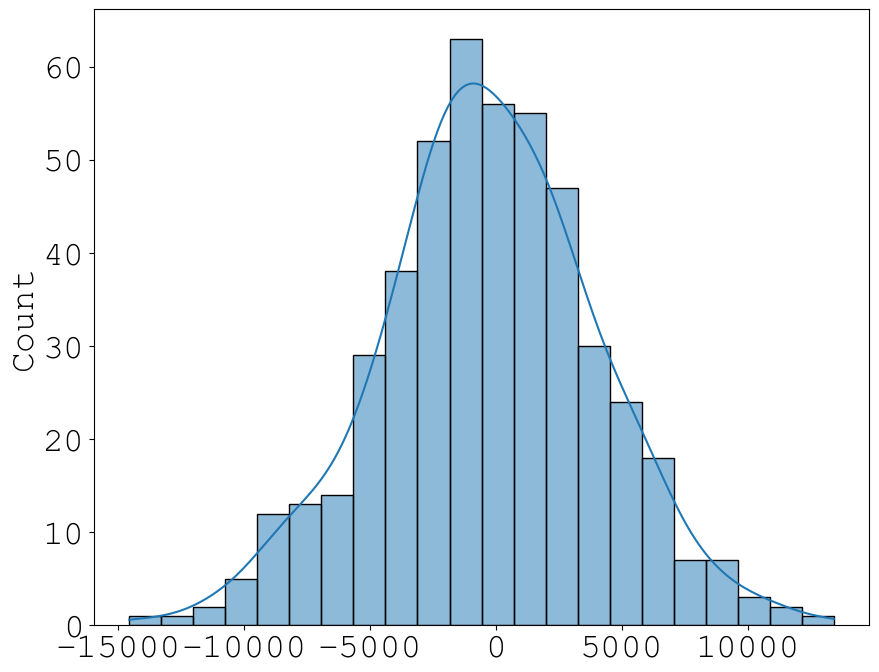

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

FONT_SIZE =25
    
plt.rcParams.update({
    'font.family': 'Courier New',
    'font.size': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'figure.titlesize': FONT_SIZE
})

differences = np.array(data1) - np.array(data2)
num_zeros = np.sum(differences == 0)

print(f"Number of zero differences: {num_zeros} out of {len(differences)}")

differences = [a - b for a, b in zip(data1, data2)]
plt.figure(figsize=(10, 8))
sns.histplot(differences, kde=True)
# plt.title("Distribution of Pairwise Differences")
plt.show()

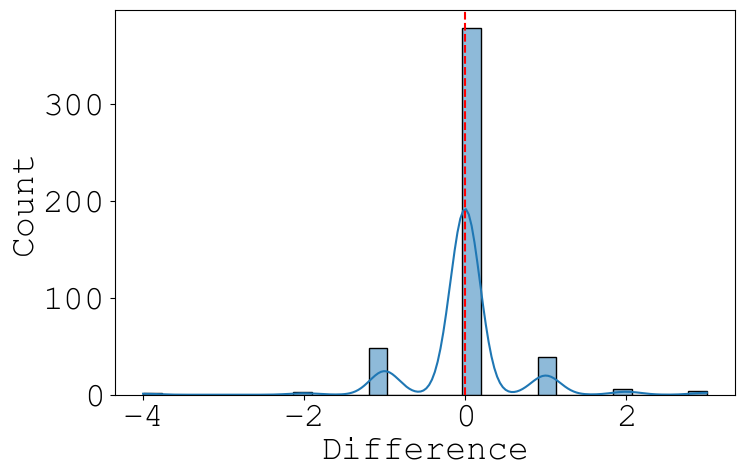

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

differences = np.array(data1) - np.array(data2)

plt.figure(figsize=(8, 5))
sns.histplot(differences, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Difference")
plt.show()


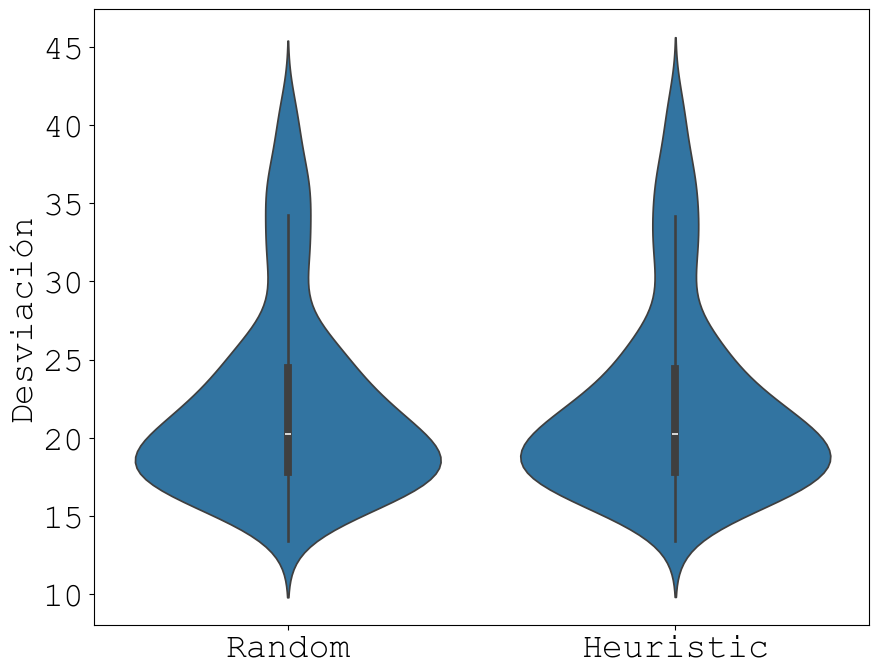

In [74]:
import pandas as pd

df = pd.DataFrame({
    "Random": data1,
    "Heuristic": data2
})

df_melted = df.melt(var_name="", value_name="Desviación")

plt.figure(figsize=(10, 8))
sns.violinplot(x="", y="Desviación", data=df_melted, inner="box")
plt.savefig(f"../Assets/violin-auc-{dataset}.pdf")
plt.show()

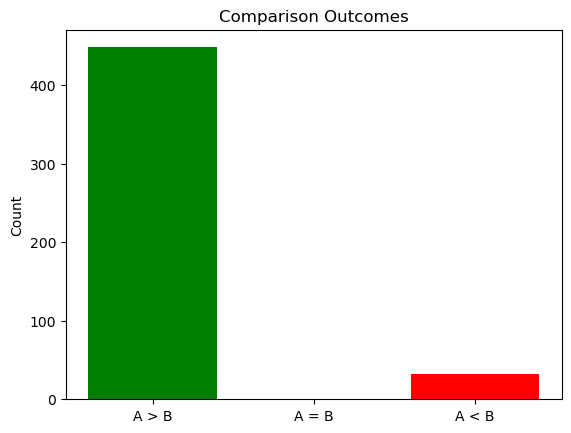

In [26]:
a = np.array(data1)
b = np.array(data2)
diffs = a - b

counts = {
    "A > B": np.sum(diffs > 0),
    "A = B": np.sum(diffs == 0),
    "A < B": np.sum(diffs < 0)
}

plt.bar(counts.keys(), counts.values(), color=["green", "gray", "red"])
plt.title("Comparison Outcomes")
plt.ylabel("Count")
plt.show()